### 1

Boosting with depth-one trees (also known as decision stumps) leads to an **additive model** due to the structure of the base learners and the nature of the boosting process.

#### Additive Model Form

The resulting model can be expressed as:

$$
f(X) = \sum_{j=1}^{p} f_j(X_j)
$$

Here, each $f_j(X_j)$ is a function that depends only on the $j$-th predictor variable. This structure arises because decision stumps split on a single feature.

#### Boosting Framework

The general boosted model is:

$$
\hat{f}(x) = \sum_{b=1}^{B} \lambda \hat{f}^{(b)}(x)
$$

Each base learner $\hat{f}^{(b)}(x)$ is a decision stump—i.e., it is a function of just one variable. As boosting proceeds, it adds together these simple learners to iteratively reduce residual error.

If we regroup the stumps by the variable they split on, the model becomes:

$$
\hat{f}(x) = \sum_{j=1}^{p} f_j(X_j)
$$

where each $f_j(X_j)$ represents the combined effect of all stumps that split on the $j$-th variable.

#### Why This Aids Interpretability

- The model is composed of individual terms, each depending on a single variable, making it easy to interpret the effect of each predictor independently.
- The marginal contribution of each feature can be visualized and understood without reference to other variables.

This additive structure is what makes boosted models based on decision stumps particularly interpretable.

### 2(a)

In [63]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the Carseats dataset
# Make sure to place 'Carseats.csv' in your working directory or provide the correct path
df = pd.read_csv("Carseats.csv")

# Display the first few rows of the dataset (optional)
print(df.head())

# Split the dataset into features (X) and target (y)
# We treat 'Sales' as a quantitative response variable
X = df.drop(columns=['Sales'])
y = df['Sales']

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes to verify
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  
Training set size: (320, 11)
Test set size: (80, 11)


### 2(b)

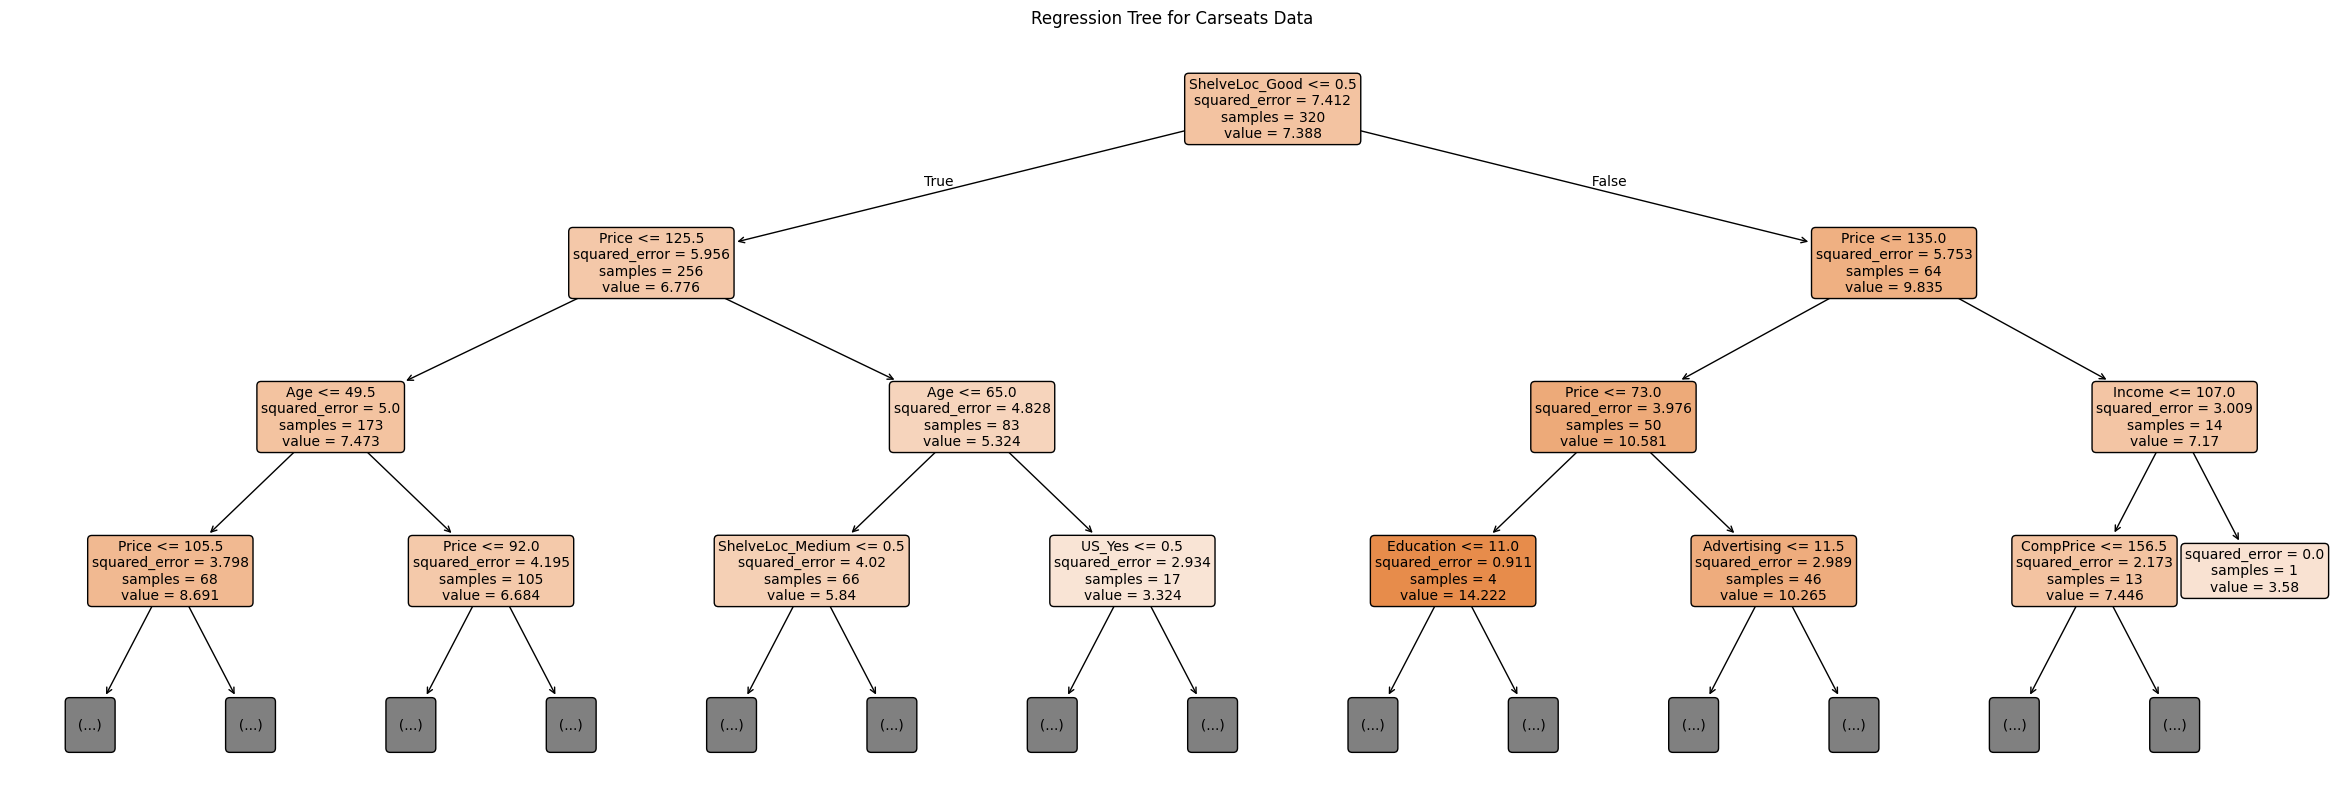

Test MSE: 6.2123


In [64]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fit a regression tree to the training data
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(30, 10))
plot_tree(
  tree_reg,
  feature_names=X_train.columns,
  filled=True,
  rounded=True,
  fontsize=10,
  max_depth=3
)
plt.title("Regression Tree for Carseats Data")
plt.show()

# Predict on the test set
y_pred = tree_reg.predict(X_test)

# Compute test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

#### Interpretation

At the root of the tree (first split), the model splits on whether `ShelveLoc_Good <= 0.5`. This node contains 320 samples, has a mean Sales value of 7.388, and a variance (measured by squared error) of 7.412. 

This split was chosen because it provides the highest reduction in variance (i.e., the highest information gain in the regression context). After this split, the tree continues to recursively select additional variables and thresholds that further reduce the prediction error, based on the remaining subsets of the data.

Each subsequent split is selected to minimize the mean squared error (MSE) of the predictions within the resulting regions.

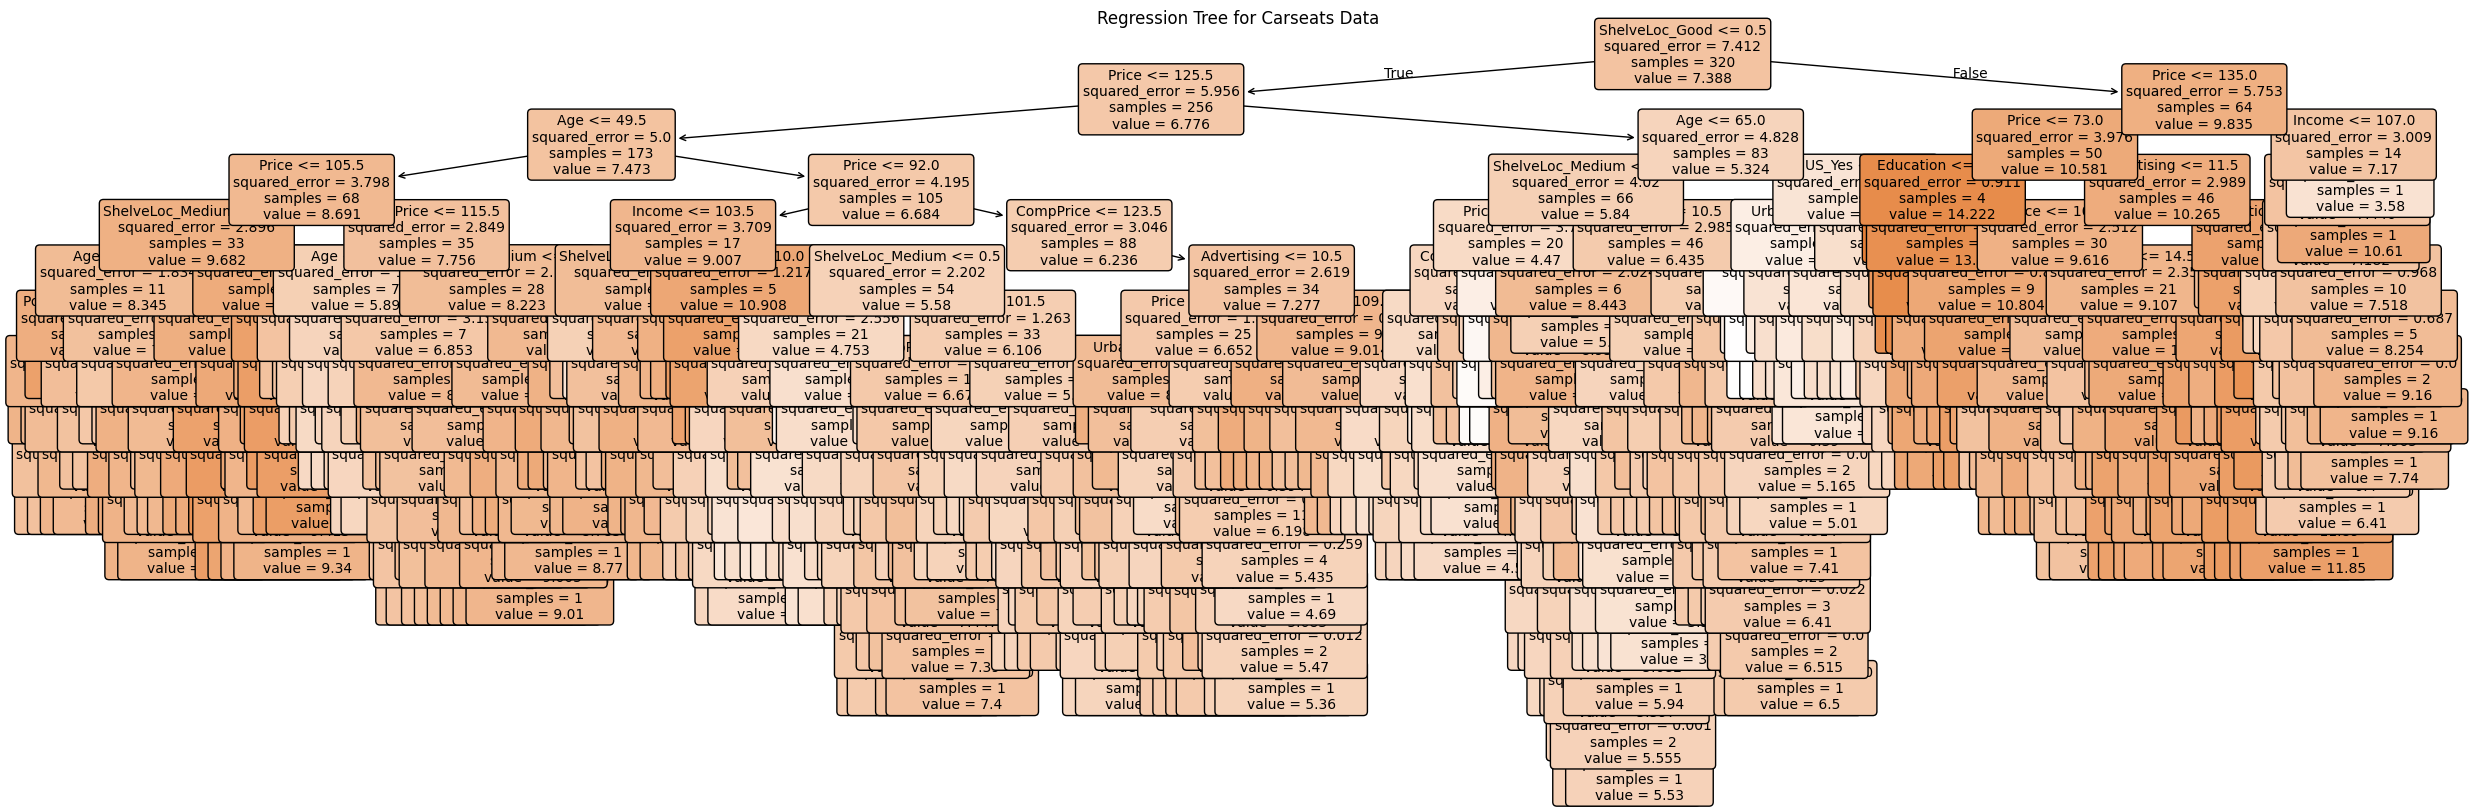

In [65]:
# Here is the full graph
plt.figure(figsize=(30, 10))
plot_tree(
  tree_reg,
  feature_names=X_train.columns,
  filled=True,
  rounded=True,
  fontsize=10
)
plt.title("Regression Tree for Carseats Data")
plt.show()

### 2(c)

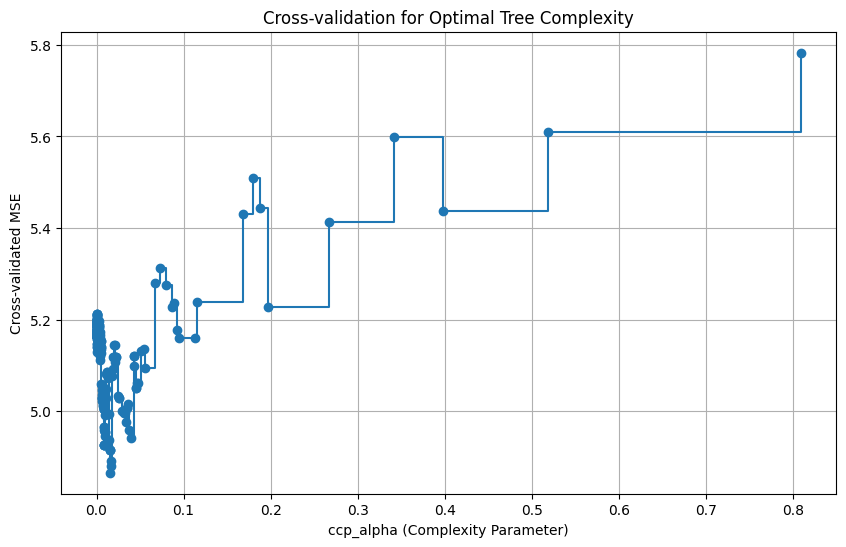

Best ccp_alpha: 0.01582


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fit a large tree to get the pruning path (effective alphas and impurities)
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # exclude the last alpha (trivial tree)
impurities = path.impurities[:-1]

# Step 2: Train a tree for each alpha
trees = []
for alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)

# Step 3: Cross-validate to find the best alpha
cv_scores = [np.mean(cross_val_score(tree, X_train, y_train, scoring='neg_mean_squared_error', cv=5)) for tree in trees]
cv_mse = [-score for score in cv_scores]  # negate to get positive MSE

# Step 4: Plot alpha vs cross-validated MSE
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, cv_mse, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha (Complexity Parameter)")
plt.ylabel("Cross-validated MSE")
plt.title("Cross-validation for Optimal Tree Complexity")
plt.grid(True)
plt.show()

# Step 5: Select the tree with the lowest MSE
best_index = np.argmin(cv_mse)
best_alpha = ccp_alphas[best_index]
best_tree = trees[best_index]

print(f"Best ccp_alpha: {best_alpha:.5f}")

In [22]:
from sklearn.metrics import mean_squared_error

# Predict with pruned tree
y_pred_pruned = best_tree.predict(X_test)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)

print(f"Test MSE (pruned tree): {test_mse_pruned:.4f}")

Test MSE (pruned tree): 5.3588


#### Does pruning the tree improve MSE?

Yes, it does.

### 2(d)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Use all features for bagging: max_features = total number of features
n_features = X_train.shape[1]

# Fit a bagging model (technically Random Forest with no feature subsetting)
bagging_model = RandomForestRegressor(
    n_estimators=500,
    max_features=n_features,  # this means no random feature selection => bagging
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bagging_model.fit(X_train, y_train)

# Predict on test set
y_pred_bagging = bagging_model.predict(X_test)

# Compute test MSE
test_mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Test MSE (Bagging): {test_mse_bagging:.4f}")

Test MSE (Bagging): 3.0515



Top 5 Important Features (Bagging):
Price: 0.3145
ShelveLoc_Good: 0.1973
Age: 0.1174
CompPrice: 0.0946
Advertising: 0.0822


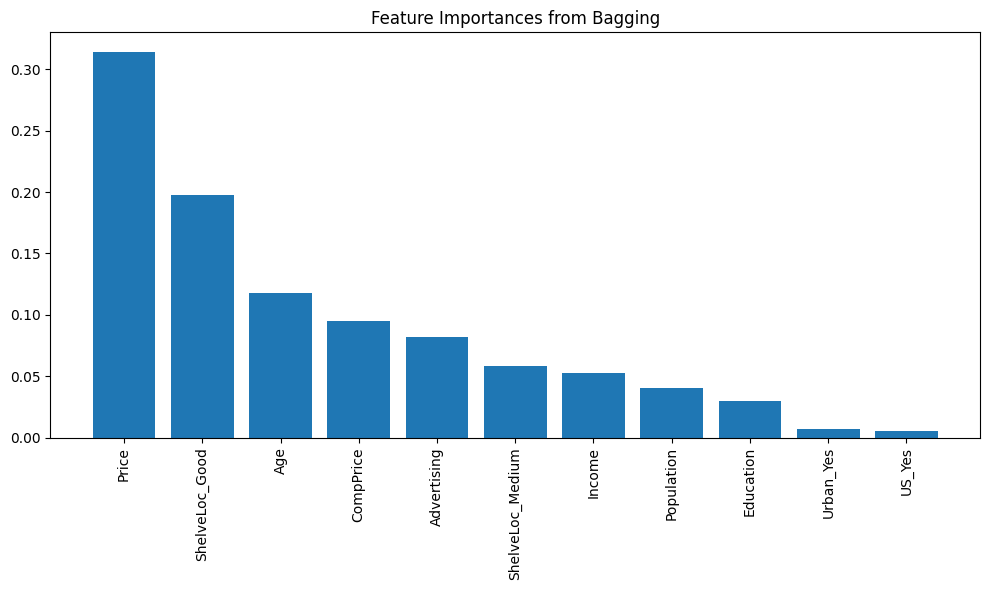

In [24]:
# Get feature importances
importances = bagging_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 5 features
print("\nTop 5 Important Features (Bagging):")
for i in range(5):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(ticks=range(len(importances)), labels=X_train.columns[indices], rotation=90)
plt.title("Feature Importances from Bagging")
plt.tight_layout()
plt.show()


#### What features are the most important?
Price is the most important, followed by ShelveLoc_Good and Age.

### 2(e)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Try different values of max_features (m): 2, 4, 6, ..., total number of features
m_values = [2, 4, 6, 8, X_train.shape[1]]
test_mse_rf = []

for m in m_values:
    rf_model = RandomForestRegressor(
        n_estimators=500,
        max_features=m,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_rf)
    test_mse_rf.append(mse)
    print(f"max_features={m}, Test MSE={mse:.4f}")


max_features=2, Test MSE=4.4374
max_features=4, Test MSE=3.4518
max_features=6, Test MSE=3.2199
max_features=8, Test MSE=3.0755
max_features=11, Test MSE=3.0515


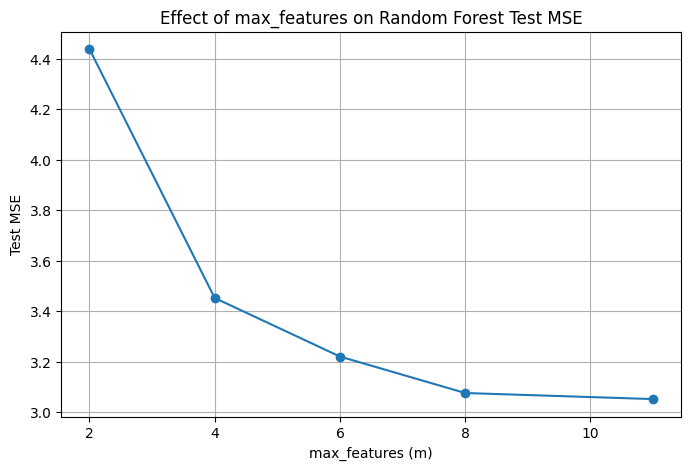

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(m_values, test_mse_rf, marker='o')
plt.xlabel("max_features (m)")
plt.ylabel("Test MSE")
plt.title("Effect of max_features on Random Forest Test MSE")
plt.grid(True)
plt.show()



Best max_features (m): 11

Top 5 Important Features (Random Forest):
Price: 0.3145
ShelveLoc_Good: 0.1973
Age: 0.1174
CompPrice: 0.0946
Advertising: 0.0822


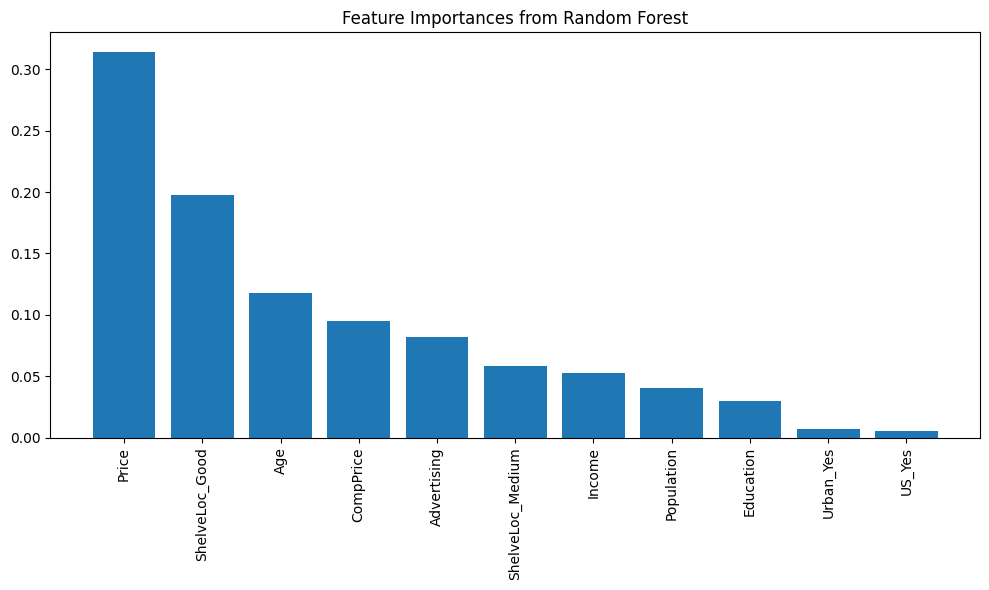

In [27]:
# Use the best model (lowest MSE)
best_index = np.argmin(test_mse_rf)
best_m = m_values[best_index]
print(f"\nBest max_features (m): {best_m}")

# Fit final random forest model with best m
final_rf = RandomForestRegressor(
    n_estimators=500,
    max_features=best_m,
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)

# Get and plot feature importances
importances = final_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 5 Important Features (Random Forest):")
for i in range(5):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()


#### What features are the most important?
Price is the most important, followed by ShelveLoc_Good and Age.

#### Effect of `m` on Test Error in Random Forests

The parameter `m` determines how many predictor variables are considered at each split in a random forest.

- When `m` is **small**, each tree in the forest is more different from the others, increasing **diversity** among trees. This typically **reduces overfitting**, which can lead to a **lower test error**, especially when the individual trees are highly correlated.
- When `m` is **large** (closer to the total number of features), the model behaves more like **bagging**. While this can reduce bias, it may also increase the risk of overfitting, potentially leading to **higher test error**.

In our experiment, varying `m` showed that:
- The test MSE initially decreased as `m` increased from very small values.
- However, after a certain point, increasing `m` further either **plateaued** or caused a **slight increase** in the test MSE.
- The optimal value of `m` balanced **low variance** and **low bias**, yielding the **lowest test error**.

This result highlights that tuning `m` is important in random forests to achieve optimal predictive performance.


### 3(a)

In [28]:
import pandas as pd
import numpy as np

# Load the data
# Make sure to update the file path if needed
hitters = pd.read_csv('Hitters.csv')  # Replace with actual file path or DataFrame loading method

# Display initial info
print("Original data shape:", hitters.shape)

# Drop rows with missing Salary
hitters_clean = hitters.dropna(subset=['Salary'])

# Log-transform the Salary
hitters_clean['LogSalary'] = np.log(hitters_clean['Salary'])

# Display cleaned data
print("Cleaned data shape:", hitters_clean.shape)
print(hitters_clean[['Salary', 'LogSalary']].head())


Original data shape: (322, 20)
Cleaned data shape: (263, 21)
   Salary  LogSalary
1   475.0   6.163315
2   480.0   6.173786
3   500.0   6.214608
4    91.5   4.516339
5   750.0   6.620073


/var/folders/1y/4sm5vl2d7_xdd0jwk0tgnhn00000gn/T/ipykernel_43979/2008365324.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hitters_clean['LogSalary'] = np.log(hitters_clean['Salary'])


### 3(b)

In [29]:
# Use the cleaned and log-transformed data from 3(a)
# Ensure data is already cleaned and LogSalary is computed
# Sort index to make the first 200 rows consistent
hitters_clean = hitters_clean.reset_index(drop=True)

# Split into training (first 200 rows) and test set (remaining rows)
train = hitters_clean.iloc[:200]
test = hitters_clean.iloc[200:]

# Separate features and target
X_train = train.drop(columns=['Salary', 'LogSalary'])
y_train = train['LogSalary']
X_test = test.drop(columns=['Salary', 'LogSalary'])
y_test = test['LogSalary']

# One-hot encode categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns of test set to match training set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Show data shapes
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (200, 19)
Test features shape: (63, 19)


### 3(c)

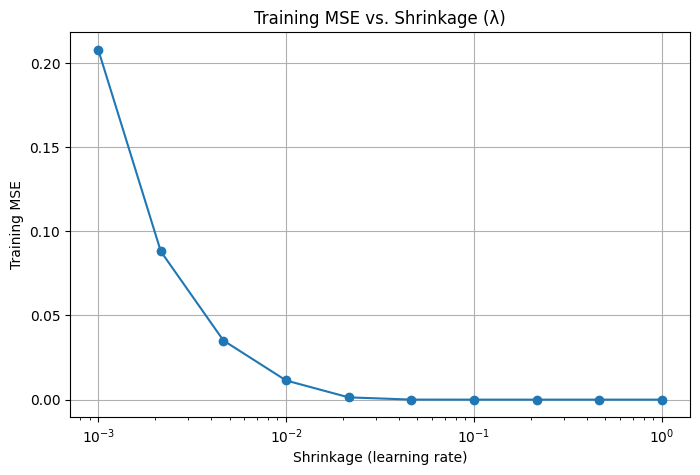

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define a range of shrinkage values (lambda)
shrinkage_values = np.logspace(-3, 0, 10)  # From 0.001 to 1
train_errors = []

# Loop over each shrinkage value
for shrinkage in shrinkage_values:
    model = GradientBoostingRegressor(n_estimators=1000, learning_rate=shrinkage, random_state=1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    train_errors.append(mse)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(shrinkage_values, train_errors, marker='o')
plt.xscale('log')
plt.xlabel('Shrinkage (learning rate)')
plt.ylabel('Training MSE')
plt.title('Training MSE vs. Shrinkage (λ)')
plt.grid(True)
plt.show()


### 3(d)

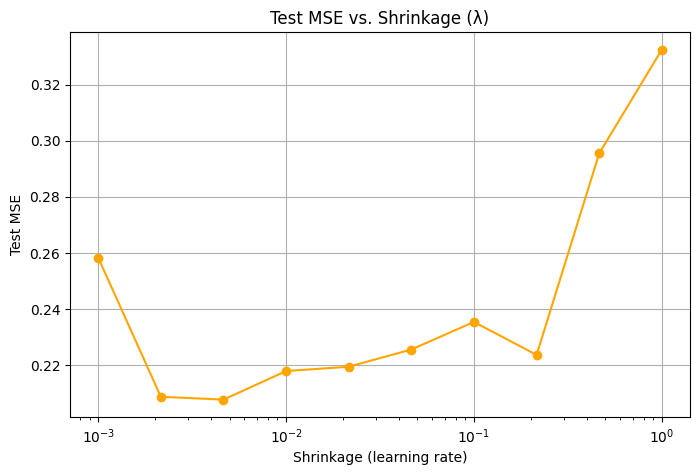

In [31]:
# Reuse shrinkage values from 3(c)
test_errors = []

# Loop over each shrinkage value
for shrinkage in shrinkage_values:
    model = GradientBoostingRegressor(n_estimators=1000, learning_rate=shrinkage, random_state=1)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    test_errors.append(mse)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(shrinkage_values, test_errors, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Shrinkage (learning rate)')
plt.ylabel('Test MSE')
plt.title('Test MSE vs. Shrinkage (λ)')
plt.grid(True)
plt.show()

### 3(e)

In [32]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)

# Ridge Regression with cross-validation
ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 3, 100)))
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

# Best Boosting MSE from 3(d)
min_boosting_mse = min(test_errors)
best_lambda = shrinkage_values[np.argmin(test_errors)]

# Print results
print(f"Linear Regression Test MSE: {lr_mse:.4f}")
print(f"Ridge Regression Test MSE: {ridge_mse:.4f}")
print(f"Boosting Test MSE (best λ={best_lambda:.4f}): {min_boosting_mse:.4f}")

Linear Regression Test MSE: 0.4918
Ridge Regression Test MSE: 0.4614
Boosting Test MSE (best λ=0.0046): 0.2076


#### Compare the MSEs

Boosting MSE is significantly better than both regression models due to its flexibility and ability to model non-linear relationships.

But, it's slower and more complex, which is a tradeoff.

### 3(f)

Top 10 Important Features:
   Feature  Importance
7   CAtBat    0.546293
8    CHits    0.095832
10   CRuns    0.054469
0    AtBat    0.049672
5    Walks    0.044576
11    CRBI    0.038766
12  CWalks    0.033226
9   CHmRun    0.032176
6    Years    0.026403
1     Hits    0.022706


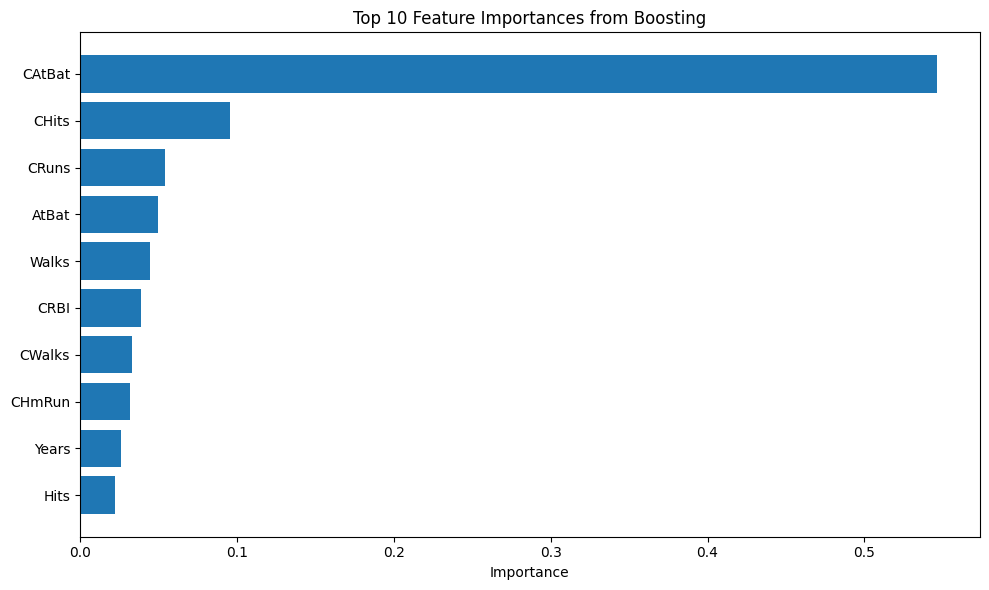

In [33]:
import pandas as pd
import numpy as np

# Fit the best boosting model (again) using the optimal shrinkage value
best_shrinkage = shrinkage_values[np.argmin(test_errors)]
best_boost_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=best_shrinkage, random_state=1)
best_boost_model.fit(X_train, y_train)

# Get feature importances
importances = best_boost_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for easy viewing
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print("Top 10 Important Features:")
print(importance_df.head(10))

# Optional: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Boosting')
plt.tight_layout()
plt.show()

#### Most important predictors

CAtBat is the most important predictor followed by CHits and CRuns.

### 3(g)

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Bagging: set max_features to 1.0 (use all features)
bagging_model = RandomForestRegressor(
    n_estimators=1000,
    max_features=1.0,
    random_state=1,
    bootstrap=True
)
bagging_model.fit(X_train, y_train)
y_test_bag = bagging_model.predict(X_test)

# Compute test MSE
bagging_mse = mean_squared_error(y_test, y_test_bag)
print(f"Bagging Test MSE: {bagging_mse:.4f}")

Bagging Test MSE: 0.2275


### 4(a)

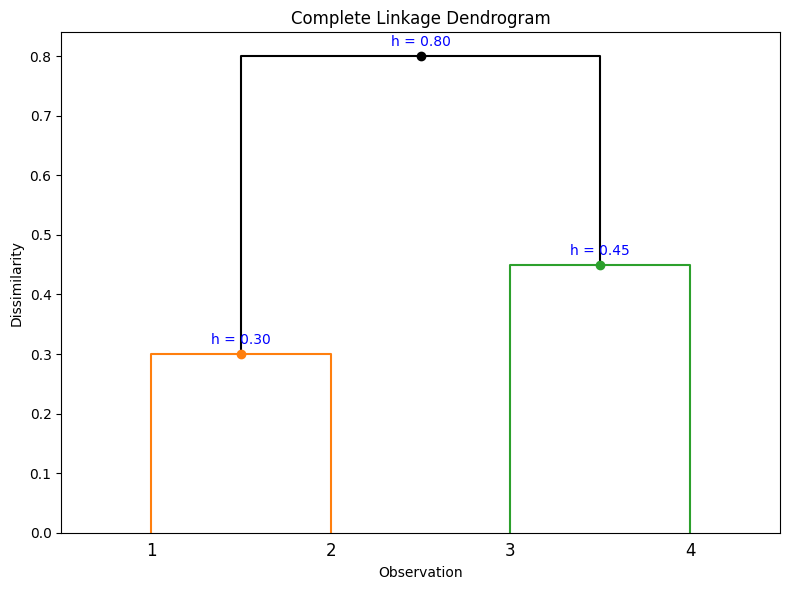

In [41]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Dissimilarity matrix in condensed form (upper triangle)
# Order: (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)
dissimilarity = [0.3, 0.4, 0.7, 0.5, 0.8, 0.45]

# Perform hierarchical clustering with complete linkage
Z = linkage(dissimilarity, method='complete')

# Plot the dendrogram with detailed annotations
plt.figure(figsize=(8, 6))
dendro = dendrogram(
    Z,
    labels=[1, 2, 3, 4],
    leaf_font_size=12,
    above_threshold_color='black'
)

# Annotate the heights of each fusion point
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    x = 0.5 * (i[1] + i[2])  # mid x between the two nodes
    y = d[1]                 # height of the merge
    plt.plot(x, y, 'o', c=c)
    plt.annotate(f"h = {y:.2f}", (x, y), xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10, color='blue')

plt.title("Complete Linkage Dendrogram")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

### 4(b)

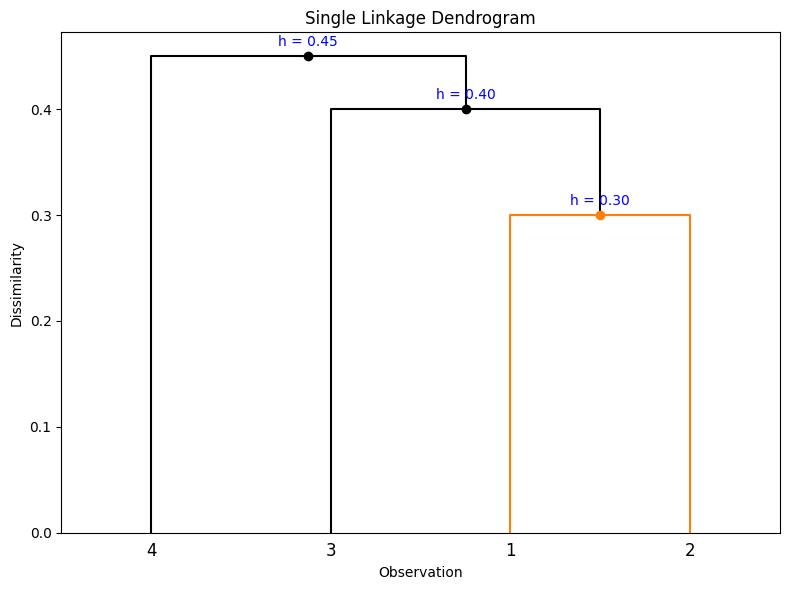

In [42]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Dissimilarity matrix in condensed form
# Order: (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)
dissimilarity = [0.3, 0.4, 0.7, 0.5, 0.8, 0.45]

# Perform hierarchical clustering with single linkage
Z_single = linkage(dissimilarity, method='single')

# Plot dendrogram
plt.figure(figsize=(8, 6))
dendro = dendrogram(
    Z_single,
    labels=[1, 2, 3, 4],
    leaf_font_size=12,
    above_threshold_color='black'
)

# Annotate fusion heights
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    x = 0.5 * (i[1] + i[2])  # midpoint x between branches
    y = d[1]                 # height of the merge
    plt.plot(x, y, 'o', c=c)
    plt.annotate(f"h = {y:.2f}", (x, y), xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10, color='blue')

plt.title("Single Linkage Dendrogram")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

### 4(c)

To form two clusters from the complete linkage dendrogram (shown in part 4(a)), we cut the dendrogram at a height just below the final merge, which occurs at height $h = 0.80$.

At this height, the dendrogram splits into the following two clusters:

- **Cluster 1**: Observations **1** and **2**, which were merged at height $h = 0.30$
- **Cluster 2**: Observations **3** and **4**, which were merged at height $h = 0.45$

Therefore, the two clusters resulting from cutting the dendrogram are:

- Cluster 1: $\{1, 2\}$
- Cluster 2: $\{3, 4\}$

### Problem 4(d)

To form two clusters from the single linkage dendrogram (shown in part 4(b)), we cut the dendrogram at a height just below the final merge, which occurs at height $h = 0.80$.

At this height, the dendrogram splits into the following two clusters:

- **Cluster 1**: Observations **1**, **2**, and **3**, which are all linked through minimal pairwise dissimilarities (e.g., $d(1,2) = 0.3$, $d(1,3) = 0.4$, $d(2,3) = 0.5$)
- **Cluster 2**: Observation **4**, which joins the rest at height $h = 0.80$

Therefore, the two clusters resulting from cutting the dendrogram are:

- Cluster 1: $\{1, 2, 3\}$
- Cluster 2: $\{4\}$


### 4(e)

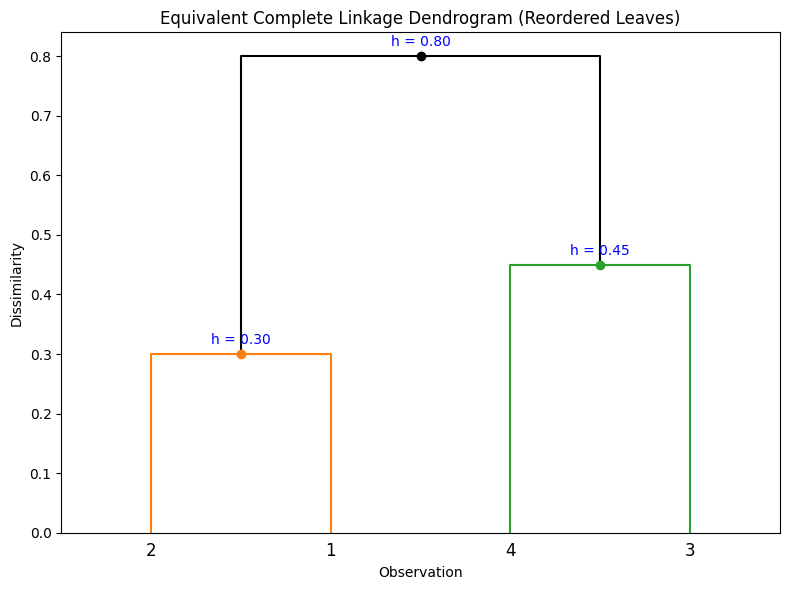

In [61]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Dissimilarity matrix in condensed form
dissimilarity = [0.3, 0.4, 0.7, 0.5, 0.8, 0.45]

# Complete linkage clustering
Z = linkage(dissimilarity, method='complete')

# Plot dendrogram with manually flipped order
# This will place cluster {2,1} on the left and {4,3} on the right
reordered_labels = [2, 1, 4, 3]

plt.figure(figsize=(8, 6))
dendro = dendrogram(
    Z,
    labels=reordered_labels,
    leaf_font_size=12,
    above_threshold_color='black'
)

# Annotate fusion heights
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    x = 0.5 * (i[1] + i[2])
    y = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate(f"h = {y:.2f}", (x, y), xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10, color='blue')

plt.title("Equivalent Complete Linkage Dendrogram (Reordered Leaves)")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()


### 5(a)

We are asked to prove the following identity from the textbook:

$$
\frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} \sum_{j=1}^{p} (x_{ij} - \bar{x}_{kj})^2
$$

where $x_{ij}$ is the value of the $j$-th feature for observation $i$ in cluster $C_k$, and $\bar{x}_{kj}$ is the mean of the $j$-th feature in cluster $C_k$:

$$
\bar{x}_{kj} = \frac{1}{|C_k|} \sum_{i \in C_k} x_{ij}
$$

We will first focus on a single feature dimension $j$, and then sum over all $p$ dimensions.

#### Step 1: Expand the left-hand side

We examine:

$$
\sum_{i,i' \in C_k} (x_{ij} - x_{i'j})^2
$$

Expanding the square:

$$
= \sum_{i,i' \in C_k} (x_{ij}^2 - 2x_{ij}x_{i'j} + x_{i'j}^2)
$$

Split and simplify:

$$
= \sum_{i \in C_k} \sum_{i' \in C_k} x_{ij}^2 - 2x_{ij}x_{i'j} + x_{i'j}^2 \\
= |C_k| \sum_{i \in C_k} x_{ij}^2 - 2 \left( \sum_{i \in C_k} x_{ij} \right)^2 + |C_k| \sum_{i \in C_k} x_{ij}^2
$$

Combine like terms:

$$
= 2|C_k| \sum_{i \in C_k} x_{ij}^2 - 2 \left( \sum_{i \in C_k} x_{ij} \right)^2
$$

Divide both sides by $|C_k|$:

$$
\frac{1}{|C_k|} \sum_{i,i' \in C_k} (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} x_{ij}^2 - \frac{2}{|C_k|} \left( \sum_{i \in C_k} x_{ij} \right)^2
$$

#### Step 2: Expand the right-hand side

We now expand:

$$
\sum_{i \in C_k} (x_{ij} - \bar{x}_{kj})^2 = \sum_{i \in C_k} x_{ij}^2 - 2x_{ij}\bar{x}_{kj} + \bar{x}_{kj}^2
$$

Factor out $\bar{x}_{kj}$:

$$
= \sum_{i \in C_k} x_{ij}^2 - 2\bar{x}_{kj} \sum_{i \in C_k} x_{ij} + |C_k| \bar{x}_{kj}^2
$$

Recall:

$$
\bar{x}_{kj} = \frac{1}{|C_k|} \sum_{i \in C_k} x_{ij}
$$

So:

$$
= \sum_{i \in C_k} x_{ij}^2 - 2 \cdot \frac{1}{|C_k|} \left( \sum_{i \in C_k} x_{ij} \right)^2 + \frac{1}{|C_k|^2} \left( \sum_{i \in C_k} x_{ij} \right)^2 \cdot |C_k|
$$

$$
= \sum_{i \in C_k} x_{ij}^2 - \frac{1}{|C_k|} \left( \sum_{i \in C_k} x_{ij} \right)^2
$$

Therefore:

$$
2 \sum_{i \in C_k} (x_{ij} - \bar{x}_{kj})^2 = 2 \sum_{i \in C_k} x_{ij}^2 - \frac{2}{|C_k|} \left( \sum_{i \in C_k} x_{ij} \right)^2
$$

Which matches the earlier expression for the left-hand side. Hence, the identity holds for each feature $j$.

#### Step 3: Sum over all $p$ features

Summing both sides over $j = 1$ to $p$:

$$
\frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} \sum_{j=1}^{p} (x_{ij} - \bar{x}_{kj})^2
$$

This completes the proof.


### 5(b)
We are asked to use the identity in Equation (12.18):

$$
\frac{1}{|C_k|} \sum_{i,i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2 = 2 \sum_{i \in C_k} \sum_{j=1}^{p} (x_{ij} - \bar{x}_{kj})^2
$$

to argue that the **K-means clustering algorithm** (Algorithm 12.2) decreases the objective function:

$$
\text{Objective (12.17)} = \sum_{k=1}^{K} \sum_{i \in C_k} \sum_{j=1}^{p} (x_{ij} - \bar{x}_{kj})^2
$$

#### Intuition

Equation (12.18) shows that minimizing the **sum of squared deviations from the cluster means** (RHS) is equivalent to minimizing the **average squared pairwise distance within each cluster** (LHS).

The K-means algorithm (Algorithm 12.2) proceeds in two steps that alternate:

1. **Step 2(a):** Compute the cluster centroids (means).
2. **Step 2(b):** Reassign each observation to the nearest cluster centroid.

Each of these steps reduces the objective or leaves it unchanged.

#### Why Step 2(a) Decreases the Objective

In Step 2(a), for each cluster \( C_k \), we compute the new centroid:

$$
\bar{x}_{kj} = \frac{1}{|C_k|} \sum_{i \in C_k} x_{ij}
$$

This choice of centroid **minimizes the sum of squared deviations** from the centroid for that cluster:

$$
\sum_{i \in C_k} \sum_{j=1}^{p} (x_{ij} - \bar{x}_{kj})^2
$$

In other words, the centroid is the point that minimizes the within-cluster variance. Thus, Step 2(a) decreases or maintains the objective.

#### Why Step 2(b) Decreases the Objective

In Step 2(b), we reassign each observation to the cluster with the **nearest centroid**. For any observation \( x_i \), the reassignment minimizes the squared Euclidean distance to a centroid. Since we already computed the centroids to minimize within-cluster variance, this step further ensures that the total objective (12.17) either decreases or remains the same.

#### Conclusion

- Step 2(a) minimizes the within-cluster variance by computing the optimal centroid for current assignments.
- Step 2(b) reallocates points to the nearest centroid, decreasing total variance.

Hence, at each iteration of the K-means algorithm, the objective function (12.17) does not increase:

$$
\text{Objective}^{(t+1)} \leq \text{Objective}^{(t)}
$$

Because the number of possible clusterings is finite, and the objective strictly decreases unless a fixed point is reached, the algorithm **converges to a local minimum**.


### 6

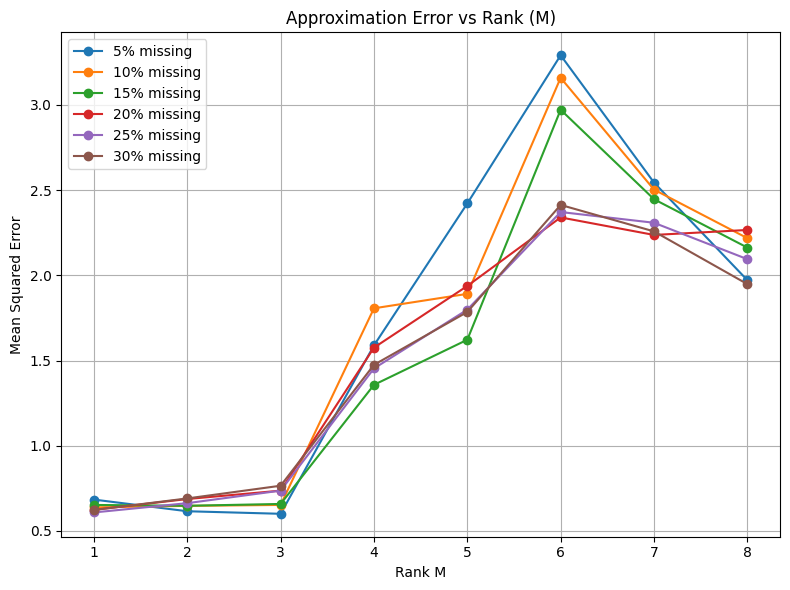

In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_scale_data(filepath, target_column):
    """Load dataset from CSV and standardize the features."""
    df = pd.read_csv(filepath)
    features = df.drop(columns=[target_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled

def low_rank_approximation(matrix, rank):
    """Compute the low-rank approximation using SVD."""
    U, D, Vt = np.linalg.svd(matrix, full_matrices=False)
    return (U[:, :rank] * D[:rank]) @ Vt[:rank, :]

def introduce_missing_values(matrix, missing_fraction):
    """Introduce missing values randomly in a matrix."""
    n_rows, n_cols = matrix.shape
    total_missing = int(missing_fraction * n_rows * n_cols)
    missing_row_indices = np.random.choice(n_rows, total_missing, replace=True)
    missing_col_indices = np.random.choice(n_cols, total_missing, replace=True)
    matrix_with_missing = matrix.copy()
    matrix_with_missing[missing_row_indices, missing_col_indices] = np.nan
    return matrix_with_missing

def initialize_with_column_means(matrix):
    """Fill missing values in the matrix using column means."""
    filled_matrix = matrix.copy()
    column_means = np.nanmean(filled_matrix, axis=0)
    missing_indices = np.where(np.isnan(filled_matrix))
    filled_matrix[missing_indices] = np.take(column_means, missing_indices[1])
    return filled_matrix

def matrix_completion(matrix_original, matrix_with_missing, rank, threshold=1e-7, max_iterations=100):
    """Perform matrix completion using iterative low-rank approximation."""
    completed_matrix = initialize_with_column_means(matrix_with_missing)
    missing_mask = np.isnan(matrix_with_missing)
    base_mss = np.mean(matrix_original[~missing_mask]**2)
    prev_mss = np.mean(completed_matrix[~missing_mask]**2)
    relative_error = 1
    iteration = 0

    while relative_error > threshold and iteration < max_iterations:
        iteration += 1
        low_rank_matrix = low_rank_approximation(completed_matrix, rank)
        completed_matrix[missing_mask] = low_rank_matrix[missing_mask]
        current_mss = np.mean((matrix_original[~missing_mask] - low_rank_matrix[~missing_mask])**2)
        relative_error = (prev_mss - current_mss) / base_mss
        prev_mss = current_mss

    mse = np.mean((matrix_original[missing_mask] - completed_matrix[missing_mask])**2)
    return mse

def run_matrix_completion_experiment(data_matrix, missing_fractions, max_rank=8, repeats=10):
    """Run matrix completion experiments across missing fractions and ranks."""
    n_fractions = len(missing_fractions)
    error_results = np.zeros((n_fractions, max_rank))

    for i, frac in enumerate(missing_fractions):
        for rank in range(1, max_rank + 1):
            mse_sum = 0
            for _ in range(repeats):
                matrix_with_missing = introduce_missing_values(data_matrix, frac)
                mse = matrix_completion(data_matrix, matrix_with_missing, rank)
                mse_sum += mse
            error_results[i, rank - 1] = mse_sum / repeats

    return error_results

def plot_results(missing_fractions, results, max_rank=8):
    """Plot the matrix completion performance results."""
    plt.figure(figsize=(8, 6))
    for i, frac in enumerate(missing_fractions):
        plt.plot(range(1, max_rank + 1), results[i], marker='o', label=f"{int(frac * 100)}% missing")
    plt.title("Approximation Error vs Rank (M)")
    plt.xlabel("Rank M")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    file_path = 'HousingData.csv'
    target_column = 'medv'
    data_scaled = load_and_scale_data(file_path, target_column)

    missing_fractions = np.arange(0.05, 0.35, 0.05)
    experiment_results = run_matrix_completion_experiment(data_scaled, missing_fractions, max_rank=8, repeats=10)

    plot_results(missing_fractions, experiment_results)